In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

import sys
import tensorflow as tf
import keras

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


from pandas_datareader import DataReader
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.arima_model import ARIMA, ARMA
import matplotlib.pyplot as plt

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    path = '/content/drive/MyDrive/Time_series/'
except:
    path = ''

Mounted at /content/drive


# подгрузка данных

In [ ]:
def get_df(tickers, start, finish):
  
  """
  Take list of tickers and date of start and end, 
  download price changes between this dates and 
  return dataframe with this data
  """

  df=pd.DataFrame()
  for i in tickers:
    df[i] = DataReader(i,  'yahoo', start, finish)['Close']
  # расчет доходности (процентного изменения)

  return df

In [ ]:
tickers = ['AMZN', 'AAPL','T','CSCO','MU','NVDA','F','KO','AMD','INTC']


In [ ]:
tickers = ['AMZN', 'AAPL','T','CSCO','MU','NVDA','F','KO','AMD','INTC','CVX','PYPL', 'PFE', 'FB','MRK','DAL','AAL','UAL','NRG','FSLR']
tickers = tickers[:10]

df_all = dict()

for ticker in tickers:
  df = get_df([ticker], datetime(2015,1,1), datetime(2021,1,1))
  df.columns = ['Close']
  df_all[ticker] = df


In [ ]:
tickers

['AMZN', 'AAPL', 'T', 'CSCO', 'MU', 'NVDA', 'F', 'KO', 'AMD', 'INTC']

In [ ]:
df_all['AMZN']

,Close
Date,
2015-01-02,308.519989
2015-01-05,302.190002
2015-01-06,295.290009
2015-01-07,298.420013
2015-01-08,300.459991
...,...
2020-12-24,3172.689941
2020-12-28,3283.959961
2020-12-29,3322.000000


# Preprocessing

In [ ]:
for ticker in tickers:
    df_all[ticker]['pct_ch'] = df_all[ticker]['Close'].pct_change()
    df_all[ticker]["p1"] = df_all[ticker]['pct_ch'].shift(1)
    df_all[ticker]["p2"] = df_all[ticker]['pct_ch'].shift(2)
    df_all[ticker]["p3"] = df_all[ticker]['pct_ch'].shift(3)

    df_all[ticker]["weekday"] = df_all[ticker].index.weekday

    df_all[ticker]['median'] = df_all[ticker]['pct_ch'].rolling(22, min_periods = 1).median()
    df_all[ticker]['Q1'] = df_all[ticker]['pct_ch'].rolling(22, min_periods = 1).quantile(0.25)
    df_all[ticker]['Q3'] = df_all[ticker]['pct_ch'].rolling(22, min_periods = 1).quantile(0.75)
    df_all[ticker]['mean'] = df_all[ticker]['pct_ch'].rolling(22, min_periods = 1).mean()


In [ ]:
train_all = dict()
test_all = dict()

for ticker in tickers:
    train = df_all[ticker][df_all[ticker].index < datetime(2018, 12, 31)]
    test = df_all[ticker][df_all[ticker].index > datetime(2019, 1, 1)]

    train_all[ticker] = train 
    test_all[ticker] = test 

In [ ]:
train_all['AMZN'] 

,Close,pct_ch,p1,p2,p3,weekday,median,Q1,Q3,mean
Date,,,,,,,,,,
2015-01-02,308.519989,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN
2015-01-05,302.190002,-0.020517,NaN,NaN,NaN,0,-0.020517,-0.020517,-0.020517,-0.020517
2015-01-06,295.290009,-0.022833,-0.020517,NaN,NaN,1,-0.021675,-0.022254,-0.021096,-0.021675
2015-01-07,298.420013,0.010600,-0.022833,-0.020517,NaN,2,-0.020517,-0.021675,-0.004959,-0.010917
2015-01-08,300.459991,0.006836,0.010600,-0.022833,-0.020517,3,-0.006841,-0.021096,0.007777,-0.006479
...,...,...,...,...,...,...,...,...,...,...
2018-12-21,1377.449951,-0.057077,-0.022908,-0.036352,0.020100,4,-0.001217,-0.032991,0.013756,-0.003692
2018-12-24,1343.959961,-0.024313,-0.057077,-0.022908,-0.036352,0,-0.001217,-0.033343,0.013756,-0.004291
2018-12-26,1470.900024,0.094452,-0.024313,-0.057077,-0.022908,2,-0.001217,-0.033343,0.016929,-0.000645


# ARMA

## подбор параметров

In [ ]:
# pq_dict = dict()

# result_dict = dict()

# for ticker in tickers:
#     ps = range(0, 5)
#     d=0
#     qs = range(0, 4)

#     from itertools import product

#     parameters = product(ps, qs)
#     parameters_list = list(parameters)
#     len(parameters_list)

#     %%time
#     results = []
#     best_aic = float("inf")

#     for param in tqdm(parameters_list):
#         #try except нужен, потому что на некоторых наборах параметров модель не обучается
#         try:
#             model=ARMA(df_all[ticker].pct_ch[1:], order=(param[0], param[1])).fit()
#         #выводим параметры, на которых модель не обучается и переходим к следующему набору
#         except ValueError:
#             print('wrong parameters:', param)
#             continue
#         aic = model.aic
#         #сохраняем лучшую модель, aic, параметры
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])

#     warnings.filterwarnings('default')

#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
#     result_table = result_table.sort_values(by = 'aic', ascending=True)\

#     results_dict[ticker] = result_table
    
#     pq = result_table.iloc[0, 0]
#     if pq == (0, 0):
#       pq = result_table.iloc[1, 0]


#     pq_dict[ticker] = pq

#     #print(result_table.sort_values(by = 'aic', ascending=True).head())

# pq_df = pd.DataFrame(pq_dict).T
# pq_df.columns = ['p', 'q']
# pq_df['pq'] = list(zip(pq_df.p.values.tolist(), pq_df.q.values.tolist()))
# pq_df

# pq_df.to_csv('/content/drive/MyDrive/Time_series/ARMA_params.csv')


In [ ]:
pq_df = pd.read_csv(path + 'ARMA_params.csv', index_col = 0)
pq_df.loc[['AMD'], ['p']] = 3
pq_df.loc[['AMD'], ['q']] = 0

pq_df['pq'] = list(zip(pq_df.p.values.tolist(), pq_df.q.values.tolist()))
pq_df

,p,q,pq
AMZN,4,1,"(4, 1)"
AAPL,4,2,"(4, 2)"
T,4,3,"(4, 3)"
CSCO,3,2,"(3, 2)"
MU,4,3,"(4, 3)"
NVDA,3,1,"(3, 1)"
F,4,3,"(4, 3)"
KO,4,1,"(4, 1)"
AMD,3,0,"(3, 0)"
INTC,3,1,"(3, 1)"


In [ ]:
def tsplot(y, X=[[-1000000]], lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        if X[0][0] != -1000000:
            print("Критерий Гольдфельда-Квандта: p=%f" % sms.diagnostic.het_goldfeldquandt(y, X)[1])
        print("Критерий Дарбина-Уотсона: %f" % durbin_watson(y))

        plt.tight_layout()
    return 

In [ ]:
models_ARMA_dict = dict()

for ticker in tickers:
    print(ticker)
    params = pq_df.loc[ticker, ['pq']].values[0]
    print(params)

    model = ARMA(train_all[ticker]['pct_ch'][1:], order=pq_df.loc[ticker, ['pq']].values[0])
    model_fit = model.fit(disp=0)

    models_ARMA_dict[ticker] = model_fit


AMZN
(4, 1)
AAPL
(4, 2)
T
(4, 3)
CSCO
(3, 2)
MU
(4, 3)
NVDA
(3, 1)
F
(4, 3)
KO
(4, 1)
AMD
(3, 0)
INTC
(3, 1)


In [ ]:
models_ARMA_dict['AMZN'].forecast(505)[0]

In [ ]:
predictions_arima = dict()
metrics_dict = dict()

for ticker in tickers:
    pred = models_ARMA_dict[ticker].forecast(505)[0]
    predictions_arima[ticker] = pred
    diff = pred - test_all[ticker].pct_ch

    mse = np.mean(diff**2)
    mae = np.mean(abs(diff))
    rmse = mse ** 0.5

    metrics_dict[ticker] = [mse, mae, rmse]


In [ ]:
metrics = pd.DataFrame(metrics_dict, index = ['MSE', 'MAE', 'RMSE']).T
metrics['model'] = ['ARMA'] * len(tickers)
metrics

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AAPL,0.000575,0.016093,0.023983,ARMA
T,0.000322,0.011577,0.017939,ARMA
CSCO,0.000463,0.013764,0.021528,ARMA
MU,0.001044,0.023196,0.032304,ARMA
NVDA,0.000988,0.022123,0.031431,ARMA
F,0.000781,0.018115,0.027949,ARMA
KO,0.000295,0.010926,0.017167,ARMA
AMD,0.001315,0.024964,0.036257,ARMA
INTC,0.000708,0.016293,0.026609,ARMA


# Classical ML models

## LINREG

In [ ]:
model_lin_dict = dict()

for ticker in tickers:
    X = train_all[ticker][['p1', 'p2', 'p3', 'weekday', 'median', 'Q1', 'Q3']][4:]
    y = train_all[ticker].pct_ch[4:]

    lr = LinearRegression()
    lr.fit(X, y)

    model_lin_dict[ticker] = lr

In [ ]:
model_lin_dict

{'AAPL': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'AMD': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'AMZN': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'CSCO': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'F': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'INTC': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'KO': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'MU': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'NVDA': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'T': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}

In [ ]:
predictions_lin = dict()
metrics_dict = dict()

for ticker in tickers:

    X_test = test_all[ticker][['p1', 'p2', 'p3', 'weekday', 'median', 'Q1', 'Q3']]
    pred = model_lin_dict[ticker].predict(X_test)
    predictions_lin[ticker] = pred
    diff = pred - test_all[ticker].pct_ch

    mse = np.mean(diff**2)
    mae = np.mean(abs(diff))
    rmse = mse ** 0.5

    metrics_dict[ticker] = [mse, mae, rmse]

In [ ]:
metrics_lin = pd.DataFrame(metrics_dict, index = ['MSE', 'MAE', 'RMSE']).T
metrics_lin['model'] = ['lin'] * len(tickers)
metrics = pd.concat([metrics, metrics_lin])
metrics

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AAPL,0.000575,0.016093,0.023983,ARMA
T,0.000322,0.011577,0.017939,ARMA
CSCO,0.000463,0.013764,0.021528,ARMA
MU,0.001044,0.023196,0.032304,ARMA
NVDA,0.000988,0.022123,0.031431,ARMA
F,0.000781,0.018115,0.027949,ARMA
KO,0.000295,0.010926,0.017167,ARMA
AMD,0.001315,0.024964,0.036257,ARMA
INTC,0.000708,0.016293,0.026609,ARMA


In [ ]:
pred_lin_amzn = (predictions_lin['AMZN'] + 1)[1:] * test_all['AMZN']['Close'][:-1]

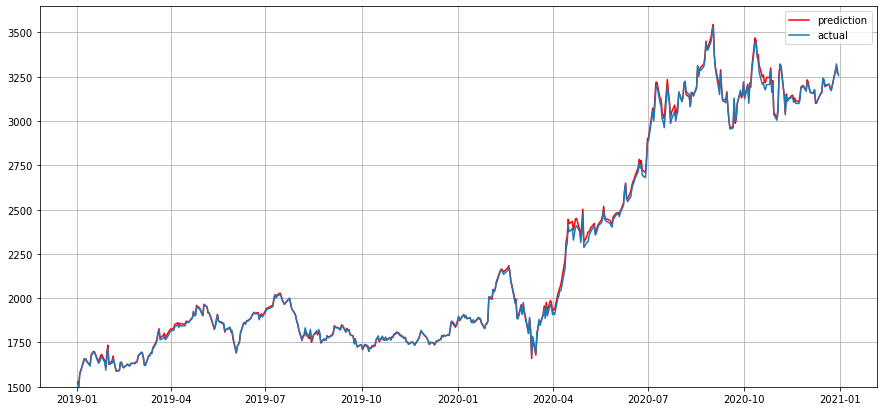

In [ ]:
answer = (predictions_lin['AMZN'] + 1)[1:] * test_all['AMZN']['Close'][:-1]
close = test_all['AMZN']['Close'][1:]

plt.figure(figsize=(15, 7))
plt.plot(answer, "r", label="prediction")
plt.plot(close, label="actual")
plt.legend(loc="best")
#plt.title("XGB\n Mean absolute error {} $".format(round(mean_absolute_error(answer, close), 5)))
plt.ylim(bottom = 1500)
plt.grid(True)

## Random Forest

In [ ]:
model_rf_dict = dict()

for ticker in tickers:
  X = train_all[ticker][['p1', 'p2', 'p3', 'weekday', 'median', 'Q1', 'Q3']][4:]
  y = train_all[ticker].pct_ch[4:]

  rf = RandomForestRegressor()
  rf.fit(X, y)

  model_rf_dict[ticker] = rf

In [ ]:
model_rf_dict

{'AAPL': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'AMD': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbo

In [ ]:
predictions_rf = dict()
metrics_dict = dict()

for ticker in tickers:

    X_test = test_all[ticker][['p1', 'p2', 'p3', 'weekday', 'median', 'Q1', 'Q3']]
    pred = model_rf_dict[ticker].predict(X_test)
    predictions_rf[ticker] = pred
    diff = pred - test_all[ticker].pct_ch

    mse = np.mean(diff**2)
    mae = np.mean(abs(diff))
    rmse = mse ** 0.5

    metrics_dict[ticker] = [mse, mae, rmse]

In [ ]:
metrics_rf = pd.DataFrame(metrics_dict, index = ['MSE', 'MAE', 'RMSE']).T
metrics_rf['model'] = ['RF'] * len(tickers)
metrics = pd.concat([metrics, metrics_rf])
metrics

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AAPL,0.000575,0.016093,0.023983,ARMA
T,0.000322,0.011577,0.017939,ARMA
CSCO,0.000463,0.013764,0.021528,ARMA
MU,0.001044,0.023196,0.032304,ARMA
NVDA,0.000988,0.022123,0.031431,ARMA
F,0.000781,0.018115,0.027949,ARMA
KO,0.000295,0.010926,0.017167,ARMA
AMD,0.001315,0.024964,0.036257,ARMA
INTC,0.000708,0.016293,0.026609,ARMA


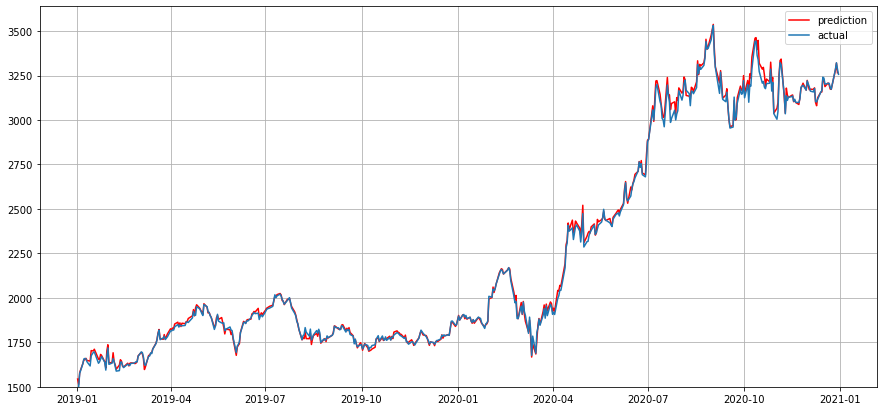

In [ ]:
answer = (predictions_rf['AMZN'] + 1)[1:] * test_all['AMZN']['Close'][:-1]
close = test_all['AMZN']['Close'][1:]

plt.figure(figsize=(15, 7))
plt.plot(answer, "r", label="prediction")
plt.plot(close, label="actual")
plt.legend(loc="best")
#plt.title("XGB\n Mean absolute error {} $".format(round(mean_absolute_error(answer, close), 5)))
plt.ylim(bottom = 1500)
plt.grid(True)

## XGB

In [ ]:
model_xgb_dict = dict()

for ticker in tickers:
  X = train_all[ticker][['p1', 'p2', 'p3', 'weekday', 'median', 'Q1', 'Q3']][4:]
  y = train_all[ticker].pct_ch[4:]

  xgb = XGBRegressor()
  xgb.fit(X, y)

  model_xgb_dict[ticker] = xgb

[10:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
model_xgb_dict

{'AAPL': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1),
 'AMD': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1),
 'AMZ

In [ ]:
predictions_xgb = dict()
metrics_dict = dict()

for ticker in tickers:

    X_test = test_all[ticker][['p1', 'p2', 'p3', 'weekday', 'median', 'Q1', 'Q3']]
    pred = model_xgb_dict[ticker].predict(X_test)
    predictions_xgb[ticker] = pred
    diff = pred - test_all[ticker].pct_ch

    mse = np.mean(diff**2)
    mae = np.mean(abs(diff))
    rmse = mse ** 0.5

    metrics_dict[ticker] = [mse, mae, rmse]

In [ ]:
metrics_xgb = pd.DataFrame(metrics_dict, index = ['MSE', 'MAE', 'RMSE']).T
metrics_xgb['model'] = ['xgb'] * len(tickers)
metrics = pd.concat([metrics, metrics_xgb])
metrics

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AAPL,0.000575,0.016093,0.023983,ARMA
T,0.000322,0.011577,0.017939,ARMA
CSCO,0.000463,0.013764,0.021528,ARMA
MU,0.001044,0.023196,0.032304,ARMA
NVDA,0.000988,0.022123,0.031431,ARMA
F,0.000781,0.018115,0.027949,ARMA
KO,0.000295,0.010926,0.017167,ARMA
AMD,0.001315,0.024964,0.036257,ARMA
INTC,0.000708,0.016293,0.026609,ARMA


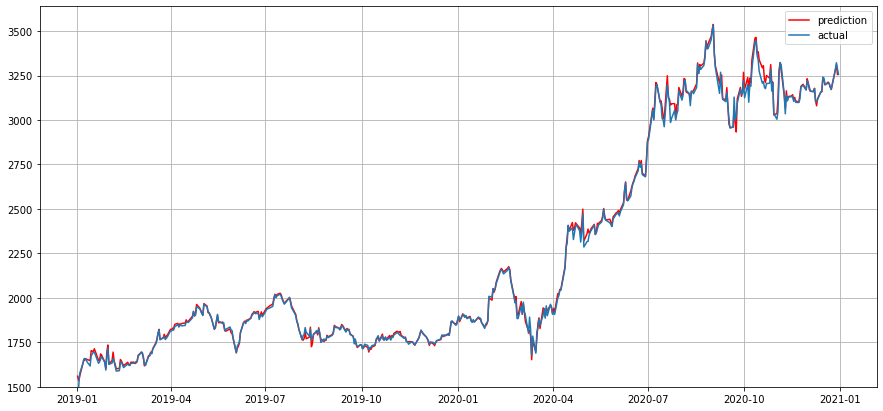

In [ ]:
answer = (predictions_xgb['AMZN'] + 1)[1:] * test_all['AMZN']['Close'][:-1]
close = test_all['AMZN']['Close'][1:]

plt.figure(figsize=(15, 7))
plt.plot(answer, "r", label="prediction")
plt.plot(close, label="actual")
plt.legend(loc="best")
plt.ylim(bottom = 1500)
plt.grid(True)

In [ ]:
metrics.loc[['AMZN']]

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AMZN,0.000382,0.013807,0.019545,lin
AMZN,0.000404,0.014479,0.020105,RF
AMZN,0.000385,0.013966,0.019634,xgb


In [ ]:
all_res = metrics.groupby(by='model', as_index = False).mean()
all_res

,model,MSE,MAE,RMSE
0,ARMA,0.000689,0.017130,0.025512
1,RF,0.000711,0.017323,0.025857
2,lin,0.000654,0.016608,0.024865
3,xgb,0.000708,0.017199,0.025802


In [ ]:
all_res_melted = pd.melt(all_res, id_vars=['model'], value_vars=['MSE', 'MAE', 'RMSE'],
        var_name='parameter')
all_res_melted

,model,parameter,value
0,ARMA,MSE,0.000689
1,RF,MSE,0.000711
2,lin,MSE,0.000654
3,xgb,MSE,0.000708
4,ARMA,MAE,0.017130
5,RF,MAE,0.017323
6,lin,MAE,0.016608
7,xgb,MAE,0.017199
8,ARMA,RMSE,0.025512
9,RF,RMSE,0.025857


In [ ]:
all_res_melted[all_res_melted.parameter != 'MSE']

,model,parameter,value
4,ARMA,MAE,0.017130
5,RF,MAE,0.017323
6,lin,MAE,0.016608
7,xgb,MAE,0.017199
8,ARMA,RMSE,0.025512
9,RF,RMSE,0.025857
10,lin,RMSE,0.024865
11,xgb,RMSE,0.025802


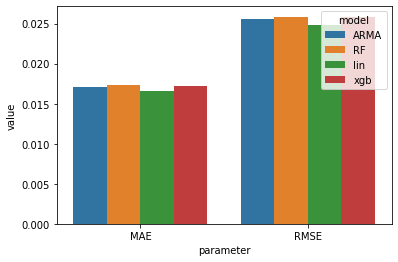

In [ ]:
sns.barplot(x="parameter", y='value', hue="model", data=all_res_melted[all_res_melted.parameter != 'MSE'])

# Neural Networks

## LSTM

In [ ]:
models_LSTM = dict()
history_LSTM = dict()

for ticker in tickers:    

    print('\n')
    print("************************************************")
    print(ticker)
    print("************************************************")
    print('\n')

    num_shape = len(train_all[ticker])

    X_train = []
    y_train = []

    window = 60
    train_loc = train_all[ticker]['pct_ch'][1:].values

    for i in range(window, num_shape-1):
    
        X_train_ = np.reshape(train_loc[i-window:i], (window, 1))
        X_train.append(X_train_)
        y_train.append(train_loc[i])

    X_train = np.stack(X_train)
    y_train = np.stack(y_train)

    # Initializing the Recurrent Neural Network
    model = Sequential()
    #Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
    #Units - dimensionality of the output space

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = 1))
    model.summary()

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(X_train, y_train, validation_split=0.25, epochs = 500, batch_size = 32)

    models_LSTM[ticker] = model
    history_LSTM[ticker] = history

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    model.save(path + 'models/model_{}_deep.h5'.format(ticker))  # creates a HDF5 file 'my_model.h5'
    #del model  # deletes the existing model




In [ ]:
models_LSTM = dict()

for ticker in tickers:
    models_LSTM[ticker] = load_model(path + 'models/model_{}_deep.h5'.format(ticker))

In [ ]:
predictions_lstm = dict()
metrics_dict = dict()
window = 60
num_shape = len(train_all[ticker])

for ticker in tickers:  
  
    model_loc = models_LSTM[ticker]
    df_volume = np.vstack((train, test))

    inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
    inputs = inputs.reshape(-1,1)
    # inputs = sc.transform(inputs)

    num_2 = df_volume.shape[0] - num_shape + window

    X_test = []

    for i in range(window, num_2):
        X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
        X_test.append(X_test_)

    X_test = np.stack(X_test)
    predict = model_loc.predict(X_test)
    print(predict.shape)

    #predictions_xgb[ticker] = pred
    diff = predict.reshape(1, -1)[0] - test_all[ticker].pct_ch

    mse = np.mean(diff**2)
    mae = np.mean(abs(diff))
    rmse = mse ** 0.5
    metrics_dict[ticker] = [mse, mae, rmse]

(505, 1)
(505, 1)
(505, 1)
(505, 1)
(505, 1)
(505, 1)
(505, 1)
(505, 1)
(505, 1)
(505, 1)


In [ ]:
answer = (predictions_lstm['AMZN'] + 1)[1:] * test_all['AMZN']['Close'][:-1]
close = test_all['AMZN']['Close'][1:]

plt.figure(figsize=(15, 7))
plt.plot(answer, "r", label="prediction")
plt.plot(close, label="actual")
plt.legend(loc="best")
#plt.title("XGB\n Mean absolute error {} $".format(round(mean_absolute_error(answer, close), 5)))
plt.ylim(bottom = 1500)
plt.grid(True)

In [ ]:
metrics_lstm = pd.DataFrame(metrics_dict, index = ['MSE', 'MAE', 'RMSE']).T
metrics_lstm['model'] = ['LSTM'] * len(tickers)
metrics = pd.concat([metrics, metrics_lstm])
metrics

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AAPL,0.000575,0.016093,0.023983,ARMA
T,0.000322,0.011577,0.017939,ARMA
CSCO,0.000463,0.013764,0.021528,ARMA
MU,0.001044,0.023196,0.032304,ARMA
NVDA,0.000988,0.022123,0.031431,ARMA
F,0.000781,0.018115,0.027949,ARMA
KO,0.000295,0.010926,0.017167,ARMA
AMD,0.001315,0.024964,0.036257,ARMA
INTC,0.000708,0.016293,0.026609,ARMA


In [ ]:
all_res = metrics.groupby(by='model', as_index = False).mean()

all_res_melted = pd.melt(all_res, id_vars=['model'], value_vars=['MSE', 'MAE', 'RMSE'],
        var_name='parameter')
all_res_melted

,model,parameter,value
0,ARMA,MSE,0.000689
1,LSTM,MSE,0.000692
2,RF,MSE,0.000707
3,lin,MSE,0.000654
4,xgb,MSE,0.000708
5,ARMA,MAE,0.017130
6,LSTM,MAE,0.017201
7,RF,MAE,0.017301
8,lin,MAE,0.016608
9,xgb,MAE,0.017199


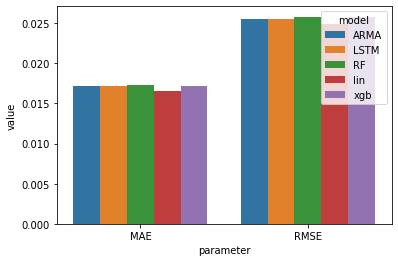

In [ ]:
sns.barplot(x="parameter", y='value', hue="model", data=all_res_melted[all_res_melted.parameter != 'MSE'])

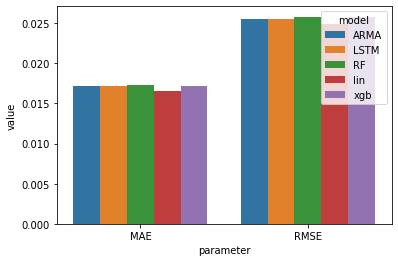

In [ ]:
sns.barplot(x="parameter", y='value', hue="model", data=all_res_melted[all_res_melted.parameter != 'MSE'])

# GRU

In [ ]:
models_GRU = dict()
history_GRU = dict()

for ticker in tickers:    

    print('\n')
    print("************************************************")
    print(ticker)
    print("************************************************")
    print('\n')

    num_shape = len(train_all[ticker])

    X_train = []
    y_train = []

    window = 60
    train_loc = train_all[ticker]['pct_ch'][1:].values

    for i in range(window, num_shape-1):
    
        X_train_ = np.reshape(train_loc[i-window:i], (window, 1))
        X_train.append(X_train_)
        y_train.append(train_loc[i])

    X_train = np.stack(X_train)
    y_train = np.stack(y_train)

    # Initializing the Recurrent Neural Network
    model = Sequential()
    #Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
    #Units - dimensionality of the output space

    model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(GRU(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 50))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = 1))
    model.summary()

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(X_train, y_train, validation_split=0.25, epochs = 500, batch_size = 32)

    models_GRU[ticker] = model
    history_GRU[ticker] = history

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    model.save(path + 'models/modelGRU_{}_deep.h5'.format(ticker))  # creates a HDF5 file 'my_model.h5'
    #del model  # deletes the existing model

In [ ]:
models_GRU = dict()

for ticker in tickers:
    models_GRU[ticker] = load_model(path + 'models/modelGRU_{}_deep.h5'.format(ticker))

In [ ]:
predictions_GRU = dict()
metrics_dict = dict()

for ticker in tickers:  
  model_loc = models_GRU[ticker]
  df_volume = np.vstack((train, test))

  inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
  inputs = inputs.reshape(-1,1)
  # inputs = sc.transform(inputs)

  num_2 = df_volume.shape[0] - num_shape + window

  X_test = []

  for i in range(window, num_2):
      X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
      X_test.append(X_test_)
      
  X_test = np.stack(X_test)
  predict = model_loc.predict(X_test)

  #predictions_xgb[ticker] = pred
  diff = predict.reshape(1, -1)[0] - test_all[ticker].pct_ch

  mse = np.mean(diff**2)
  mae = np.mean(abs(diff))
  rmse = mse ** 0.5
  metrics_dict[ticker] = [mse, mae, rmse]

In [ ]:
metrics_GRU = pd.DataFrame(metrics_dict, index = ['MSE', 'MAE', 'RMSE']).T
metrics_GRU['model'] = ['GRU'] * len(tickers)
metrics = pd.concat([metrics, metrics_GRU])
metrics

,MSE,MAE,RMSE,model
AMZN,0.000398,0.014249,0.019957,ARMA
AAPL,0.000575,0.016093,0.023983,ARMA
T,0.000322,0.011577,0.017939,ARMA
CSCO,0.000463,0.013764,0.021528,ARMA
MU,0.001044,0.023196,0.032304,ARMA
NVDA,0.000988,0.022123,0.031431,ARMA
F,0.000781,0.018115,0.027949,ARMA
KO,0.000295,0.010926,0.017167,ARMA
AMD,0.001315,0.024964,0.036257,ARMA
INTC,0.000708,0.016293,0.026609,ARMA


In [ ]:
all_res = metrics.groupby(by='model', as_index = False).median()

all_res_melted = pd.melt(all_res, id_vars=['model'], value_vars=['MSE', 'MAE', 'RMSE'],
        var_name='parameter') #.sort_values(by = 'value', ascending = True)
all_res_melted

,model,parameter,value
0,ARMA,MSE,0.000642
1,GRU,MSE,0.000639
2,LSTM,MSE,0.000640
3,RF,MSE,0.000639
4,lin,MSE,0.000593
5,xgb,MSE,0.000634
6,ARMA,MAE,0.016193
7,GRU,MAE,0.016145
8,LSTM,MAE,0.016163
9,RF,MAE,0.016070


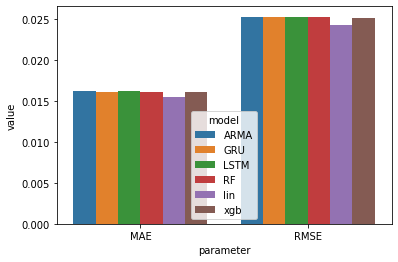

In [ ]:
sns.barplot(x="parameter", y='value', hue="model", data=all_res_melted[all_res_melted.parameter != 'MSE'])

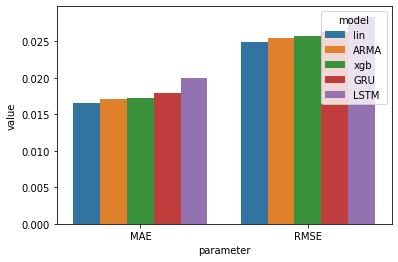

In [ ]:
sns.barplot(x="parameter", y='value', hue="model", data=all_res_melted[all_res_melted.parameter != 'MSE'])